In [1]:
from datetime import datetime, timedelta, date
from  matplotlib.ticker import PercentFormatter
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score,cross_validate 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve, KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

from numpy import mean
from numpy import std

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statistics as stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb
# from xgboost import XGBClassifier

# import re

#Read data into file
data_raw = pd.read_excel("C:/Users/caesa/Documents/UCI/Fall 2020/BANA 212/Project/global_superstore/Global_Superstore2.xlsx")


In [2]:
raw_data = data_raw.copy()
raw_data.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium


In [3]:
#Normalize column names, change date from string to date, add in a column specifically for 'year'
temp_col = []

for ele in raw_data.columns:
    col = ele.lower().split(' ')
    # print(col)
    for words in col:
        new_name = ""
        new_name += "_".join(col)
    temp_col.append(new_name)
        
raw_data.columns = temp_col
raw_data = raw_data.rename(columns = {"sub-category":"sub_category"})
    
#change data type from string to date
raw_data['order_date'] = pd.to_datetime(raw_data['order_date']).dt.date
raw_data['year']= raw_data['order_date'].apply(lambda x: x.year)

raw_data.head(3)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,year
0,32298,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,2012
1,26341,IN-2013-77878,2013-05-02,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,2013
2,25330,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,2013


In [4]:
#identify cutoff for RMF analysis, separate transaction data between cutoff period

#identify threshold between training and testing data
cutoff_date = date(2014,10,1)
min_date = raw_data['order_date'].min()
max_date = raw_data['order_date'].max()


#create accurate customer id. Start by deleting inaccurate one
customer = pd.DataFrame(raw_data['customer_name'].unique())
customer['customer_id'] = [i for i in range(1,len(customer)+1)]
customer.columns = ['customer_name', 'customer_id']
customer_dict = dict(zip(customer.iloc[:,0],customer.iloc[:,1]))

raw_data['customer_id'] = raw_data.customer_name.apply(lambda x: customer_dict[x])

#Our data starts 2011 and ends 2014. Cutoff is when we are training / tresting
tx_prior = raw_data[(raw_data.order_date < cutoff_date) & (raw_data.order_date >= min_date)].reset_index(drop=True)
tx_next = raw_data[(raw_data.order_date >= cutoff_date) & (raw_data.order_date < max_date)].reset_index(drop=True)


In [5]:
tx_prior.head(2)
tx_next.head(2)
customer.head(2)

,customer_name,customer_id
0,Rick Hansen,1
1,Justin Ritter,2


Text(0.5, 1.0, 'Number of orders per user by year')

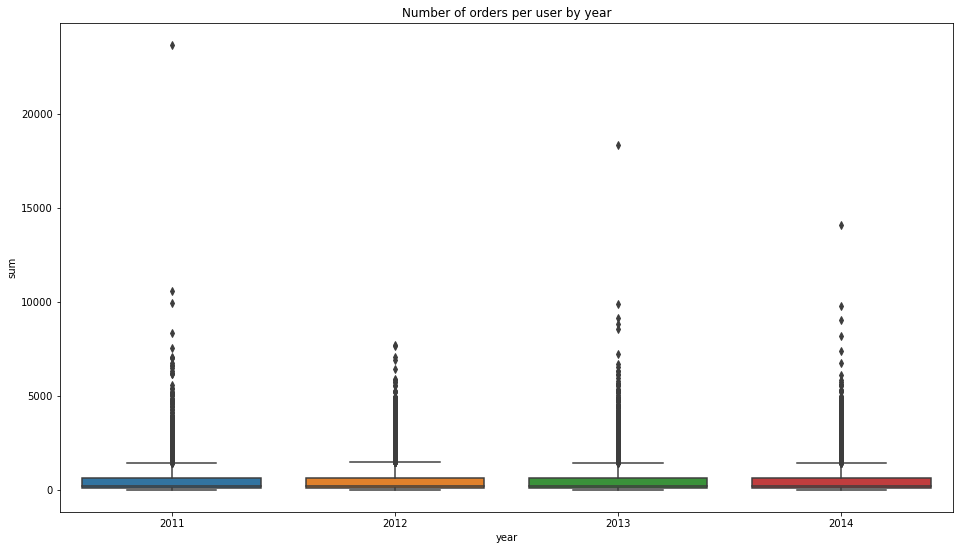

In [6]:
            ###OUTLIERS
#identifying top sales by order_id so that we can filter out outliers
outliers_total = tx_prior.groupby(['year','order_id'])['sales'].agg(
    ['sum','mean']).sort_values(by = 'sum', ascending = False).reset_index()

#Box plot of sales by order_id separated by year
fig, ax = plt.subplots(figsize=(16,9))
ax = sns.boxplot(x = 'year', y = 'sum', data = outliers_total)
plt.title('Number of orders per user by year')

In [7]:
#group orders to find total sales per order
outliers_data = tx_prior.groupby('order_id')['sales'].agg(
    ['sum','mean']).sort_values(by = 'sum', ascending = False).reset_index()

Text(0.5, 1.0, 'Number of orders per user by year')

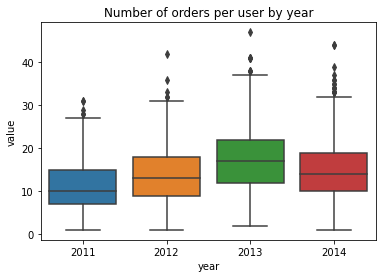

In [8]:
#ASSUME TOP 5% OF DATA consider those outliers


# create a list of all orders whos entire order (all tx an order agggregated into one observation) exceeds a certain 'limit'
outlier_limit = int(outliers_data.quantile(.95, axis = 0)[0])
outliers_trimmed = outliers_data[outliers_data['sum'] > outlier_limit]

# Identify order count to filter out non-recurring users
outliers_tx = tx_prior.groupby(['customer_id','year'])['order_id'].count().reset_index()
# outliers_tx.reset_index()
outliers_tx.columns = ['customer_id', 'year', 'num_orders']
outliers_tx = outliers_tx.pivot(index = 'customer_id', columns = 'year', values = 'num_orders')
    
#illustrates the order distribution by year (or should we filter out based on all year's total order count?)
quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
# outliers_tx.quantile(quantiles)

#Customer Order count distribution by year    
    # year  2011   2012  2013   2014
    # 0.01   1.0   2.00   4.0   3.00
    # 0.05   3.0   4.00   6.0   5.00
    # 0.25   7.0   8.00  11.0   9.00
    # 0.50   9.0  12.00  15.0  13.00
    # 0.75  14.0  16.00  20.0  17.00
    # 0.90  17.0  20.00  24.0  22.00
    # 0.95  20.0  23.00  28.0  25.00
    # 0.99  25.0  28.07  34.0  30.07

#some orders remain above 3 std 
temp_years = outliers_tx.reset_index().melt(id_vars = ['customer_id'])
ax = sns.boxplot(x = 'year', y = 'value', data = temp_years)
plt.title('Number of orders per user by year')

In [9]:
outliers_trimmed.head(5)

,order_id,sum,mean
0,CA-2011-145317,23661.228,3380.175429
1,CA-2013-118689,18336.740,3667.348000
2,CA-2014-140151,14052.480,4684.160000
3,CA-2011-139892,10539.896,1505.699429
4,CA-2011-116904,9900.190,2475.047500


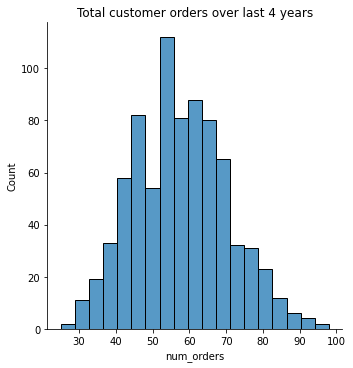

In [10]:
###Visualize posts-outlier removal, number of orders per customer
temp_overall = outliers_tx.reset_index().melt(id_vars = ['customer_id']).groupby('customer_id')['value'].sum()
temp_overall = temp_overall.reset_index().rename(columns = {'value':'num_orders'})
# temp_overall.num_orders.quantile(quantiles)

# Customer's total Order Count frequency distribution
    # 0.01    29.0
    # 0.05    34.7
    # 0.25    44.0
    # 0.50    52.0
    # 0.75    60.0
    # 0.90    67.0
    # 0.95    72.3
    # 0.99    80.0    
ax = sns.displot(temp_overall, x = 'num_orders')
plt.title('Total customer orders over last 4 years')
        #Overall most customers have over 40 orders. seems to be bell shaped distribution


# remove all orders (each transaction) associated with an outlier order's id number, "~" means NOT
tx_prior = tx_prior[~tx_prior.order_id.isin(outliers_trimmed.iloc[:,0])]

Text(0.5, 1.0, 'Order revenue by year and segment')

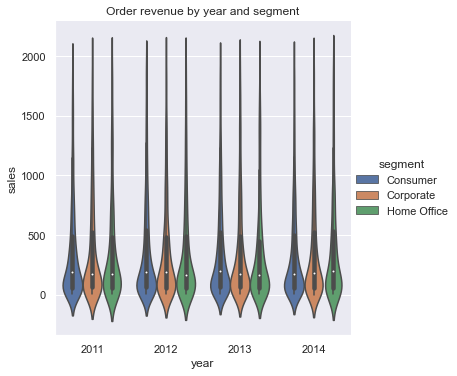

In [11]:
# Visualize sales orders by year and segment
temp_order_data = tx_prior.groupby(['order_id','year','segment'])['sales'].sum().reset_index()
sns.set_theme(style="darkgrid")
ax = sns.catplot(x = 'year', y = 'sales', hue = 'segment', data = temp_order_data, kind = 'violin')
plt.title('Order revenue by year and segment')


Text(0.5, 1.0, 'Order revenue by year')

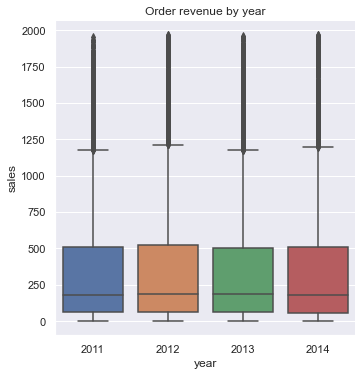

In [12]:
temp_order_data = tx_prior.groupby(['order_id','year','segment'])['sales'].sum().reset_index()
sns.set_theme(style="darkgrid")
ax = sns.catplot(x = 'year', y = 'sales', data = temp_order_data, kind = 'box')
plt.title('Order revenue by year')


In [13]:
temp_order_data.groupby('year')['sales'].mean()

year
2011    356.317567
2012    365.386764
2013    360.319518
2014    355.491807
Name: sales, dtype: float64

In [14]:
# Average salse of all orders size across all years
temp_sales_mean = tx_prior.groupby(['order_id'])['sales'].sum().reset_index()
# sns.set_theme(style="darkgrid")
# ax = sns.catplot(x = 'year', y = 'sales', hue = 'segment', data = temp_order_data, kind = 'violin')
# plt.title('Order revenue by year and segment')
temp_sales_mean['sales'].mean()

364.4752320912328

In [15]:

#identify each user's first and last orders based on cutoff date. Last oder before cutoff, first order after cutoff date
tx_last_order = tx_prior.groupby('customer_id')['order_date'].max().reset_index()
tx_first_order = tx_next.groupby('customer_id')['order_date'].min().reset_index()

#create unique list indicating days since last purchase (before cutoff date) and next purchase
cust_orders = tx_last_order.merge(tx_first_order, on = 'customer_id', how = 'left')

# len(tx_prior['customer_id'].unique())
# len(cust_orders['customer_id'].unique())

#Based on cutoff date, calculate the days between adjacent orders
cust_orders.columns = ['customer_id', 'prior_purchase', 'next_purchase']
cust_orders['days_next_order'] = cust_orders.next_purchase - cust_orders.prior_purchase
cust_orders['days_next_order'] = cust_orders['days_next_order'].dt.days
cust_orders['days_next_order'] = cust_orders['days_next_order'].fillna(999)
cust_orders['days_next_order'] = cust_orders['days_next_order'].astype(int)

In [16]:
cust_orders.head()

,customer_id,prior_purchase,next_purchase,days_next_order
0,1,2014-09-26,2014-10-09,13
1,2,2014-09-20,2014-10-27,37
2,3,2014-09-19,2014-10-14,25
3,4,2014-08-20,2014-10-02,43
4,5,2014-08-31,2014-10-28,58


In [17]:
 ###RECENCY Calculation###

#Group customers based on their invoices to find their LAST order date and how recent was it
temp = tx_prior.groupby('customer_id')['order_date'].max().reset_index()

# Last applicable date last order prior to cutoff date
last_app_date = cutoff_date - timedelta(days=1)

#calc how many days ago was the last order from cutoff date
temp['recency'] = (last_app_date - temp['order_date']).dt.days
temp.columns = ['customer_id', 'last_order_date', 'recency']

#merge these identified dates with existing df
cust_orders = pd.merge(cust_orders, temp[['customer_id','recency']], on = 'customer_id')



In [18]:
cust_orders.head(3)

,customer_id,prior_purchase,next_purchase,days_next_order,recency
0,1,2014-09-26,2014-10-09,13,4
1,2,2014-09-20,2014-10-27,37,10
2,3,2014-09-19,2014-10-14,25,11


In [19]:
#ELBOW PLOT to determine the number of clusters

#distortion avg squared distances from clusters to cluster center, i believe euclidean
#intertia: sum squared distances of sample to closest cluster center

def elbow_check(raw_data,cluster_attribute):
    
    temp_distortion = []
    cluster_range = range(1,10+1)
    
    for i in cluster_range:
        temp_kmeanmodel = KMeans(n_clusters = i, max_iter = 1000)
        temp_kmeanmodel.fit(raw_data[[cluster_attribute]])
        temp_distortion.append(temp_kmeanmodel.inertia_)
        
    plt.figure(figsize=(10,8))
    plt.plot(cluster_range, temp_distortion, 'bx-')
    plt.xlabel('Clusters')
    plt.ylabel('Distortion')
    plt.title('{}: Elbow plot to determine optimal number of clusters'.format(cluster_attribute.upper()))
    plt.show()

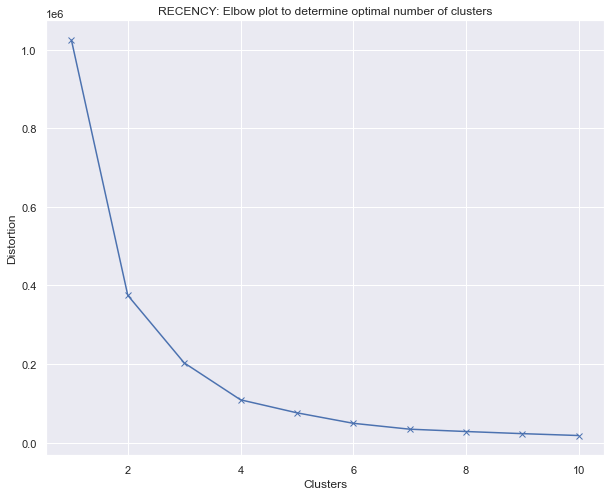

In [20]:
cluster_attribute = 'recency'
cluster_group = 'recency_cluster'
elbow_check(cust_orders, cluster_attribute)

In [21]:
####Based on Elbow plot, classify each user by their cluster
kmeans = KMeans(n_clusters = 3)
kmeans.fit(cust_orders[[cluster_attribute]])
cust_orders[cluster_group] = kmeans.predict(cust_orders[[cluster_attribute]])


In [22]:
#Re-index clusters in descending order
def order_cluster(data, cluster_name, attribute):
        
    data_new = data.groupby(cluster_name)[attribute].mean().reset_index()
    
    #sort clusters from high to low and reset value
    data_new = data_new.sort_values(by=attribute,ascending=False).reset_index(drop=True)

    data_new['index'] = data_new.index
    data = pd.merge(data,data_new[[cluster_name,'index']], on=cluster_name)
    # print(data.head(3))
    
    del data[cluster_name]
    data.rename(columns={"index":cluster_name},inplace = True)
    return data


In [23]:
#distortion avg squared distances from clusters to cluster center, i believe euclidean
#intertia: sum squared distances of sample to closest cluster center

cust_orders = order_cluster(cust_orders, cluster_group,cluster_attribute)
cust_orders.head(3)

,customer_id,prior_purchase,next_purchase,days_next_order,recency,recency_cluster
0,1,2014-09-26,2014-10-09,13,4,2
1,2,2014-09-20,2014-10-27,37,10,2
2,3,2014-09-19,2014-10-14,25,11,2


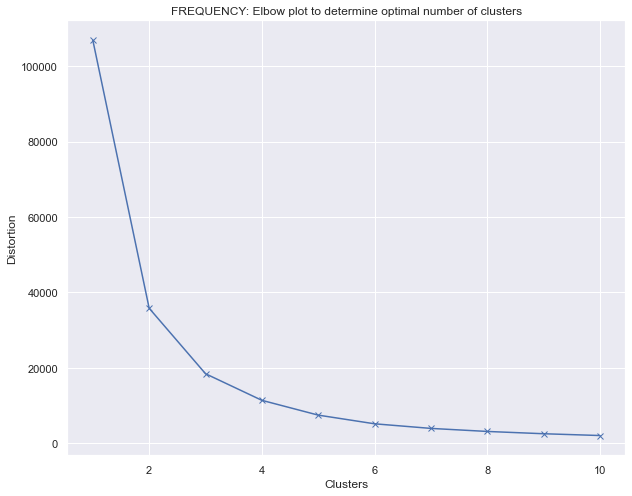

In [24]:
  ###Frequency Calculation###
temp = tx_prior.groupby('customer_id')['order_date'].count().reset_index()
temp.columns = ['customer_id','frequency']

cust_orders = pd.merge(cust_orders,temp, on = 'customer_id', how = 'left')

# sns.displot(cust_orders, x = 'frequency')
# plt.title('Total customer orders over last 4 years')

#ELBOW PLOT to determine the number of clusters
cluster_attribute = 'frequency'
cluster_group = 'freq_cluster'
elbow_check(cust_orders, cluster_attribute)



In [25]:
####Based on Elbow plot, classify each user by their cluster
kmeans = KMeans(n_clusters = 3)
kmeans.fit(cust_orders[[cluster_attribute]])
cust_orders[cluster_group] = kmeans.predict(cust_orders[[cluster_attribute]])

cust_orders = order_cluster(cust_orders, cluster_group,cluster_attribute)

In [26]:
cust_orders.head(2)

,customer_id,prior_purchase,next_purchase,days_next_order,recency,recency_cluster,frequency,freq_cluster
0,1,2014-09-26,2014-10-09,13,4,2,39,2
1,2,2014-09-20,2014-10-27,37,10,2,45,2


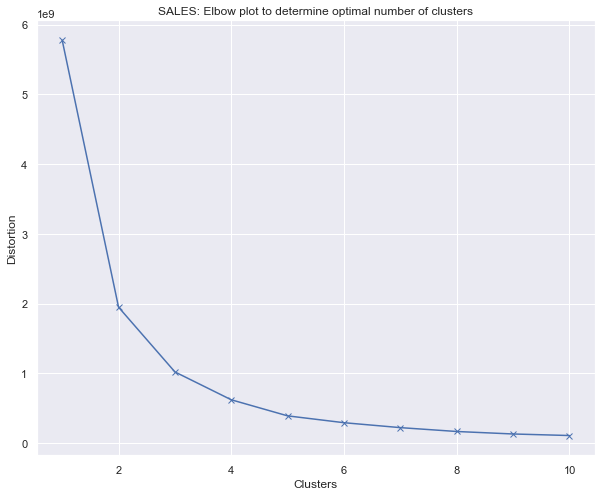

In [27]:
 ###Monetary Value Calculation###
temp = tx_prior.groupby('customer_id')['sales'].sum().reset_index()

cust_orders = pd.merge(cust_orders,temp, on = 'customer_id', how = 'left')

# sns.displot(cust_orders, x = 'sales')
# plt.title('Customer sales over last 4 years')

#ELBOW PLOT to determine the number of clusters
cluster_attribute = 'sales'
cluster_group = 'sales_cluster'
elbow_check(cust_orders, cluster_attribute)


In [28]:
####Based on Elbow plot, classify each user by their cluster
kmeans = KMeans(n_clusters = 3)
kmeans.fit(cust_orders[[cluster_attribute]])
cust_orders[cluster_group] = kmeans.predict(cust_orders[[cluster_attribute]])

cust_orders = order_cluster(cust_orders, cluster_group,cluster_attribute)

In [29]:
cust_orders.head(3)

,customer_id,prior_purchase,next_purchase,days_next_order,recency,recency_cluster,frequency,freq_cluster,sales,sales_cluster
0,1,2014-09-26,2014-10-09,13,4,2,39,2,6269.0579,2
1,2,2014-09-20,2014-10-27,37,10,2,45,2,8119.2060,2
2,12,2014-09-15,2014-10-03,18,15,2,37,2,6868.0270,2


In [30]:
                 #Overal RFM Value
cust_orders['rfm_score'] = cust_orders['sales_cluster'] + cust_orders['recency_cluster'] + cust_orders['freq_cluster']
# cust_orders.groupby('rfm_score')['recency','frequency','sales'].mean()

def rank_cust(x):
    if x <= 3:
        return 'Low_value'
    elif x <= 6:
        return 'Medium_value'
    else:
        return 'High_value'
cust_orders['cust_rank'] = cust_orders.rfm_score.apply(lambda x: rank_cust(x))

In [31]:
cust_orders.head(3)

,customer_id,prior_purchase,next_purchase,days_next_order,recency,recency_cluster,frequency,freq_cluster,sales,sales_cluster,rfm_score,cust_rank
0,1,2014-09-26,2014-10-09,13,4,2,39,2,6269.0579,2,6,Medium_value
1,2,2014-09-20,2014-10-27,37,10,2,45,2,8119.2060,2,6,Medium_value
2,12,2014-09-15,2014-10-03,18,15,2,37,2,6868.0270,2,6,Medium_value


In [32]:
                             #Days since invoice
###main driving input. Determins how many past transaction data we are evaluating

tracked_purchases = 10                        
    
purch_hist = tx_prior.sort_values(['customer_id','order_date'], ascending = False)
purch_hist = purch_hist.groupby(['customer_id','order_date']).count().reset_index()

#Sort data so that we can filter on the x recent purchases
purch_hist = purch_hist.sort_values(by =['customer_id','order_date'], ascending = [True, True])
                        
#filter data and keep only relevant columns
for col in purch_hist.columns:
    if col not in ['customer_id', "order_date"]:
        del purch_hist[col]                        

#keep only latest customer orders history
purch_hist = purch_hist.groupby('customer_id').tail(tracked_purchases)

#identify each invoice from most to least recent (1 = most, x = less recent)
purch_hist['order_date'] = pd.to_datetime(purch_hist['order_date'])
purch_hist["periods"] = purch_hist.groupby("customer_id")["order_date"].rank(ascending=False)
purch_hist['periods'] = purch_hist['periods'].astype('int')
purch_hist['order_date'] = purch_hist['order_date'].dt.date

#shape the data so that every invoice period is listed as a column
purch_hist = purch_hist.pivot(index = 'customer_id', columns = 'periods', values = 'order_date').reset_index()

#find the difference, in days, between all subsequent invoices relative to the latest invoice
rel_purch_col = []
for i in range(1,tracked_purchases):
    name = 'day_diff_' + str(i)
    purch_hist[name] = (purch_hist[1]- purch_hist[i+1]).dt.days
    rel_purch_col.append(name)
        
#Diff Between subsequent dates. Used to find standard deviation and mean between EACh purchase
temp_mean_adj_dif = []
for i in range(1,tracked_purchases):
    name = 'adj_diff' + str(i)
    purch_hist[name] = (purch_hist[i]- purch_hist[i+1]).dt.days
    temp_mean_adj_dif.append(name)
    
#Mean and STD between each purchase
extra_col = ['std','mean']

temp_mean_and_std = purch_hist.melt(id_vars = 'customer_id', value_vars = temp_mean_adj_dif, value_name = 'order_pattern')
temp_mean_and_std.sort_values(by = ['customer_id'], inplace = True)
temp_mean_and_std = temp_mean_and_std.groupby('customer_id')['order_pattern'].agg(extra_col)



In [33]:
#If exceed 12 transactions, must drop na
purch_hist.dropna()

#merge cust order data with std and mean
purch_hist = pd.merge(purch_hist, temp_mean_and_std, on = 'customer_id', how = 'left')


In [34]:
purch_hist.head(2)


,customer_id,1,2,3,4,5,6,7,8,9,...,adj_diff2,adj_diff3,adj_diff4,adj_diff5,adj_diff6,adj_diff7,adj_diff8,adj_diff9,std,mean
0,1,2014-09-26,2014-09-22,2014-08-13,2014-07-12,2014-06-06,2013-11-12,2013-09-14,2013-06-13,2013-04-08,...,40,32,36,206,59,93,66,27,59.548533,62.555556
1,2,2014-09-20,2014-09-17,2014-07-08,2014-06-20,2013-11-23,2013-11-04,2013-09-18,2013-09-02,2013-08-31,...,71,18,209,19,47,16,2,11,65.747624,44.000000


In [35]:
purch_hist.columns

Index(['customer_id',             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,            10,  'day_diff_1',
        'day_diff_2',  'day_diff_3',  'day_diff_4',  'day_diff_5',
        'day_diff_6',  'day_diff_7',  'day_diff_8',  'day_diff_9',
         'adj_diff1',   'adj_diff2',   'adj_diff3',   'adj_diff4',
         'adj_diff5',   'adj_diff6',   'adj_diff7',   'adj_diff8',
         'adj_diff9',         'std',        'mean'],
      dtype='object')

In [36]:
             ###Merge Customer Data df with Purchase History df
                

#creating this dynamic list of relevant columns for future merging
rel_purch_col += [x for x in extra_col]
        # rel_purch_col --> i.e. 'day_diff_1', 'day_diff_2', 'day_diff_3', 'std', 'mean', etc
rel_purch_col.insert(0,'customer_id') 

data = pd.merge(cust_orders, purch_hist[rel_purch_col], on = 'customer_id', how = 'left')
data.columns
#identify customers whose next purchase days are within select ranges
data.days_next_order.describe()
        # count    795.000000
        # mean      89.079245
        # std      178.281398
        # min        1.000000
        # 25%       27.000000
        # 50%       50.000000
        # 75%       79.000000
        # max      999.000000
        # Name: days_next_order, dtype: float64

#GUESSED the categorization by period. See below. We should discuss
def class_prediction(x):
    if x < 30:
       return 2
    elif x < 60:
       return 1
    else:
       return 0

#Classify individuals based on next order period
data['group_next_purchase'] = data['days_next_order'].apply(class_prediction)

data.head()

,customer_id,prior_purchase,next_purchase,days_next_order,recency,recency_cluster,frequency,freq_cluster,sales,sales_cluster,...,day_diff_3,day_diff_4,day_diff_5,day_diff_6,day_diff_7,day_diff_8,day_diff_9,std,mean,group_next_purchase
0,1,2014-09-26,2014-10-09,13,4,2,39,2,6269.0579,2,...,76,112,318,377,470,536,563,59.548533,62.555556,2
1,2,2014-09-20,2014-10-27,37,10,2,45,2,8119.2060,2,...,92,301,320,367,383,385,396,65.747624,44.000000,1
2,12,2014-09-15,2014-10-03,18,15,2,37,2,6868.0270,2,...,228,272,329,342,361,391,449,46.654165,49.888889,2
3,13,2014-09-28,2014-10-07,9,2,2,37,2,5154.4590,2,...,123,128,299,372,396,456,481,55.134180,53.444444,2
4,16,2014-09-24,2014-11-09,46,6,2,46,2,6895.7224,2,...,95,111,118,278,309,365,382,47.937749,42.444444,1


Text(0.5, 1.0, 'Data: Attribute Correlation')

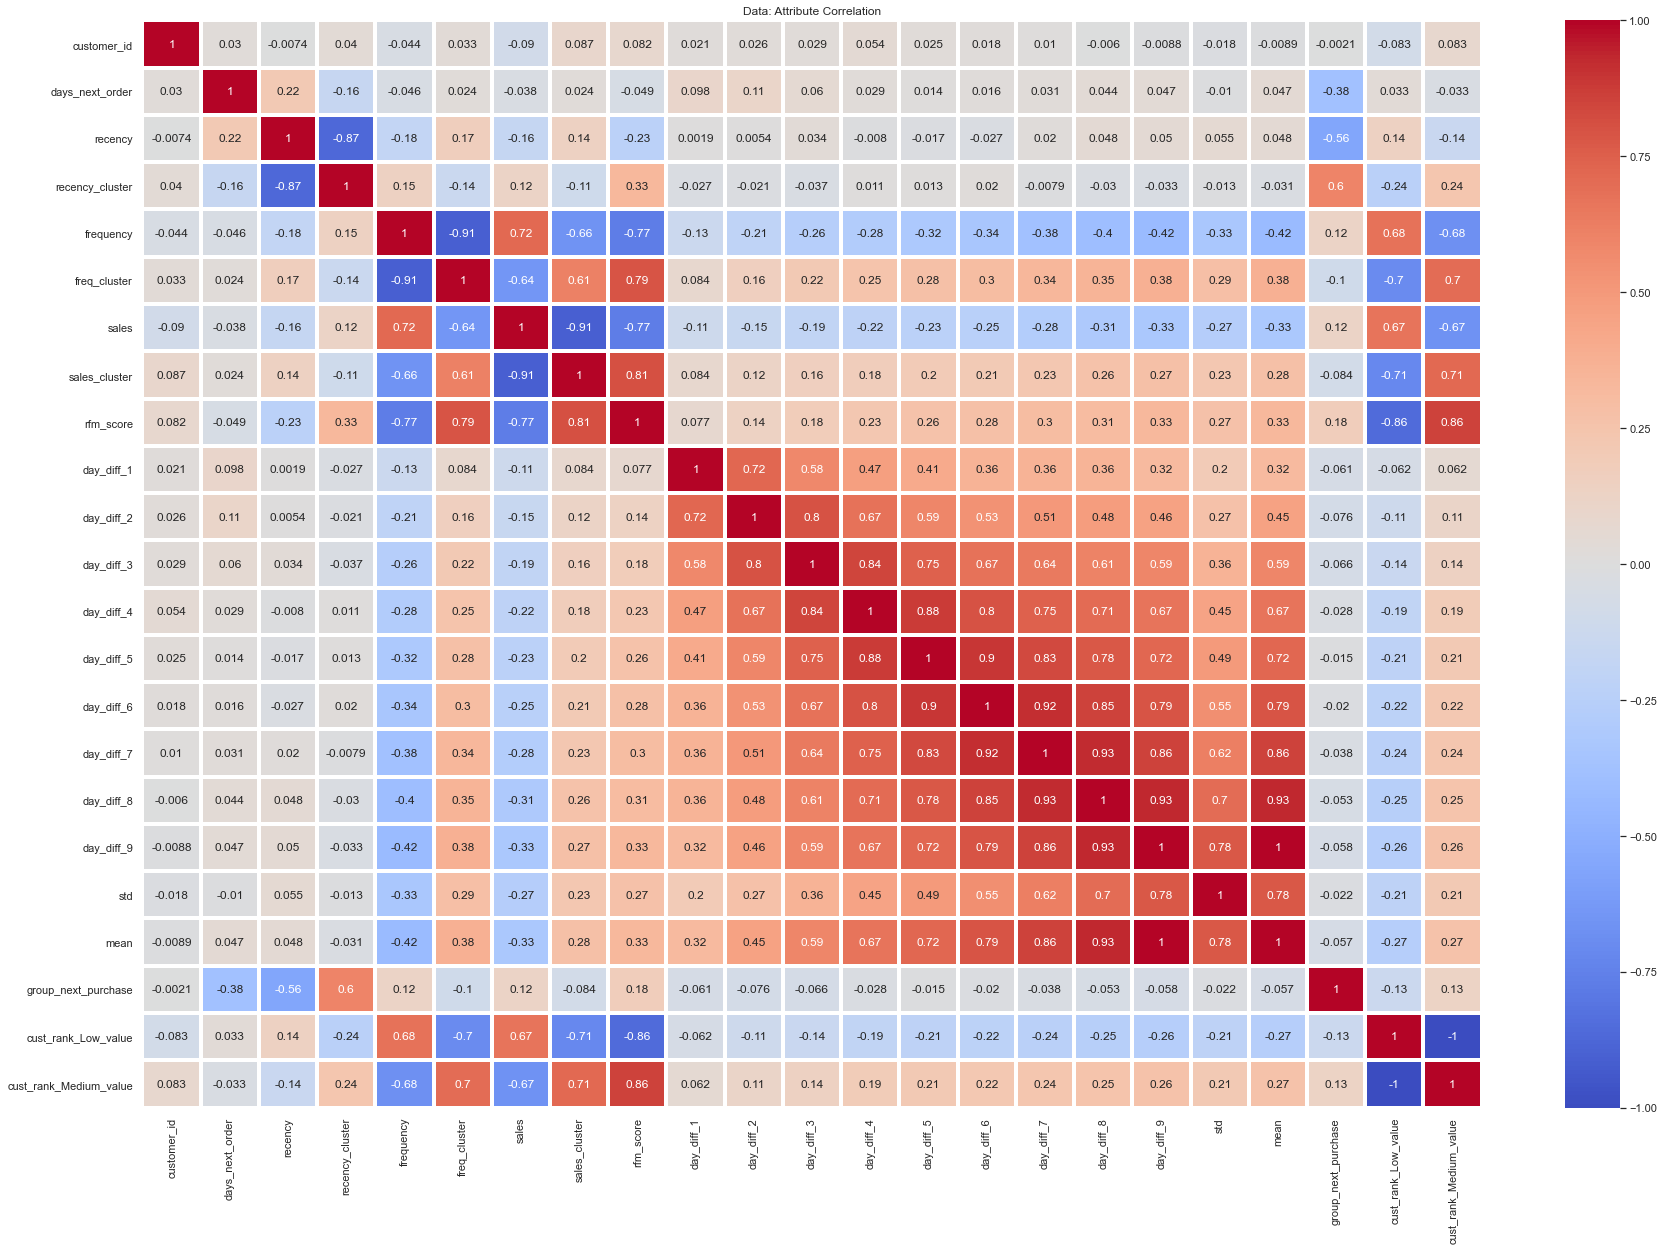

In [37]:

#removed so that the dummy variables will not be created for each date
del data['prior_purchase'], data['next_purchase']

#categorizes every categorical attribute into binary outcomes
data = pd.get_dummies(data)
##############################################################################
data['std'] = data['std'].astype('int')
data['mean'] = data['mean'].astype('int')
data['sales'] = data['sales'].astype('int')
##############################################################################
#display distribution of our assigned purchase interval classification
data.group_next_purchase.value_counts()/len(customer)
    # 0    0.550943
    # 1    0.296855
    # 2    0.152201
    # Name: group_next_purchase, dtype: float64

#heatmap to display attribute correlation to our assigned purchase interval classification
#dark red higher correlation, dark blue lower correlation
plt.figure(figsize = (30,20))
sns.heatmap(data.corr(), annot = True, vmin = -1, vmax = 1, 
            center = 0, cmap = 'coolwarm', linewidth = 3, linecolor = 'white')
plt.title('Data: Attribute Correlation')

In [38]:
### Objects explained:
    # cust_orders: RFM Score by customer_id
    # customer_dict: dictionary with each customer assigned to a new ID
    # data: cust_orders + purch_his + interval_purchase_score (attribute:group_next_purchase)
    # raw_data: data imported from excel file + year column
    # purch_hist: Customer's recent order / purchase data


                    # ML Algorithms
# Algorithms / Ranked Goals
    # Random Forest
    # Naive Bayes
    # Logistic Regression
    # Optional:
    # Adaboost?
    # Ensemble?

#Note: remember to adjust clusters, transaction periods captures, days threshold for classification, seed
    #Clusters: 3, transaction periods captured: 10,  days threshold = [30,60,61]




In [39]:

# Identify models with high accuracy and consistency
irrelevant_train_cols = ['group_next_purchase','days_next_order','customer_id']
x, y = data[data.columns.difference(irrelevant_train_cols)], data.iloc[:,data.columns == 'group_next_purchase']
y = y.values[:,0]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 123)

#10 fold cross validation of overall accuracy of each model w/ default parameters
kfold = KFold(n_splits=10, random_state=123)

cv_result_rdf = cross_val_score(RandomForestClassifier(),x_train,y_train, cv = kfold,scoring = "accuracy")
cv_result_ada = cross_val_score(AdaBoostClassifier(),x_train,y_train, cv = kfold,scoring = "accuracy")
cv_result_dt = cross_val_score(DecisionTreeClassifier(),x_train,y_train, cv = kfold,scoring = "accuracy")
cv_result_knn = cross_val_score(KNeighborsClassifier(),x_train,y_train, cv = kfold,scoring = "accuracy")
cv_result_nb = cross_val_score(GaussianNB(),x_train,y_train, cv = kfold,scoring = "accuracy")
cv_result_lr = cross_val_score(LogisticRegression(),x_train,y_train, cv = kfold,scoring = "accuracy")

cv_result_rdf
cv_result_ada
cv_result_dt
cv_result_knn
cv_result_nb
cv_result_lr

rdf_mean = cv_result_rdf.mean()
    # 0.5518
gnb_mean = cv_result_nb.mean()
    # 0.5847
dt_mean = cv_result_dt.mean()
    # 0.4930
knn_mean = cv_result_knn.mean()
    # 0.4120
ada_mean = cv_result_ada.mean()
    # 0.5377
lr_mean = cv_result_lr.mean()
    # 0.5690
    
rdf_std = cv_result_rdf.std()
    # 0.0751
gnb_std = cv_result_nb.std()
    # 0.07824
dt_std = cv_result_dt.std()
    # 0.0705
knn_std = cv_result_knn.std()
    # 0.0503
ada_std = cv_result_ada.std()
    # 0.0541
lr_std = cv_result_lr.std()
    # 0.0795


Text(0, 0.5, 'Average Accuracy Rate (%)')

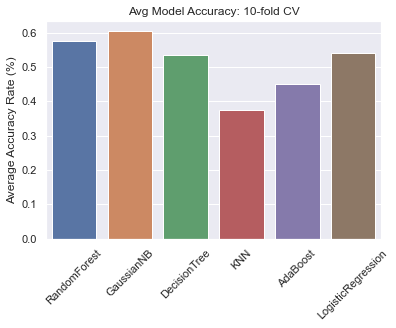

In [40]:
consider = ['RandomForest', 'GaussianNB', 'DecisionTree','KNN', 'AdaBoost', 'LogisticRegression']
overall_accuracy = [rdf_mean,gnb_mean,dt_mean,knn_mean,ada_mean,lr_mean ]

g = sns.barplot(x=consider, y=overall_accuracy)

plt.xticks(rotation=45)
plt.title('Avg Model Accuracy: 10-fold CV')
plt.ylabel('Average Accuracy Rate (%)')

Text(0, 0.5, 'Standard Deviation')

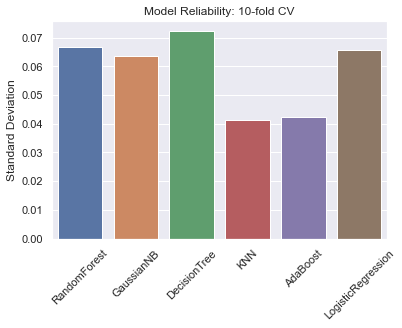

In [41]:
consider = ['RandomForest', 'GaussianNB', 'DecisionTree','KNN', 'AdaBoost', 'LogisticRegression']
overall_reliability = [rdf_std, gnb_std, dt_std,knn_std, ada_std,lr_std ]

g = sns.barplot(x=consider, y= overall_reliability)

plt.xticks(rotation=45)
plt.title('Model Reliability: 10-fold CV')
plt.ylabel('Standard Deviation')

In [42]:
#rather than 0,2,3, we will identify them based on 'risk' profile
#2 is highest risk (no purchase within 2 months)
classes=['High', 'Medium', 'Low']

#check there aren't any NAN
data.apply(lambda x: x.isnull().sum())

# check class distribution
for ele in data.group_next_purchase.unique():
    count = len(data[data['group_next_purchase'] == ele])
    dist = round(count / len(data['group_next_purchase']),2)
    print('class {}: {} accounts for {}% of the {} column'.format(ele, count,dist,'group_next_purchase'))


class 2: 233 accounts for 0.29% of the group_next_purchase column
class 1: 256 accounts for 0.32% of the group_next_purchase column
class 0: 306 accounts for 0.38% of the group_next_purchase column


Random Forest: Baseline
              precision    recall  f1-score   support

           0       0.84      0.63      0.72        68
           1       0.48      0.50      0.49        46
           2       0.50      0.67      0.57        45

    accuracy                           0.60       159
   macro avg       0.61      0.60      0.59       159
weighted avg       0.64      0.60      0.61       159



Text(0.5, 12.5, 'Prediction')

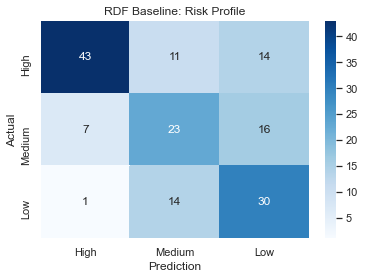

In [43]:
                    ###Random Forest First Pass - Model with default parameters

#Randomforest to predict Y values
rdf_v1 = RandomForestClassifier()
rdf_v1.fit(x_train, y_train)


y_pred_rdf_v1 = rdf_v1.predict(x_test)

print('Random Forest: Baseline')
print(classification_report(y_test, y_pred_rdf_v1))


conf_matrix_rdf_v1= confusion_matrix(y_test, y_pred_rdf_v1)


# classes=['High', 'Medium', 'Low']
conf_matrix_rdf_v1 = confusion_matrix(y_test, y_pred_rdf_v1)
df_cm_rdf_v1 = pd.DataFrame(conf_matrix_rdf_v1, index=classes, columns=classes)

ax = sns.heatmap(df_cm_rdf_v1, cmap='Blues', annot=True)
plt.title('RDF Baseline: Risk Profile')
plt.ylabel('Actual')
plt.xlabel('Prediction')

#class Distribution
# class 2: 233 accounts for 0.29% of the group_next_purchase column
# class 1: 256 accounts for 0.32% of the group_next_purchase column
# class 0: 306 accounts for 0.38% of the group_next_purchase column



Random Forest: Feature Selection
              precision    recall  f1-score   support

           0       0.82      0.60      0.69        68
           1       0.44      0.48      0.46        46
           2       0.53      0.69      0.60        45

    accuracy                           0.59       159
   macro avg       0.60      0.59      0.58       159
weighted avg       0.63      0.59      0.60       159



Text(0.5, 48.5, 'Prediction')

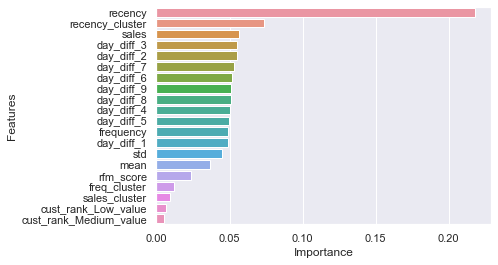

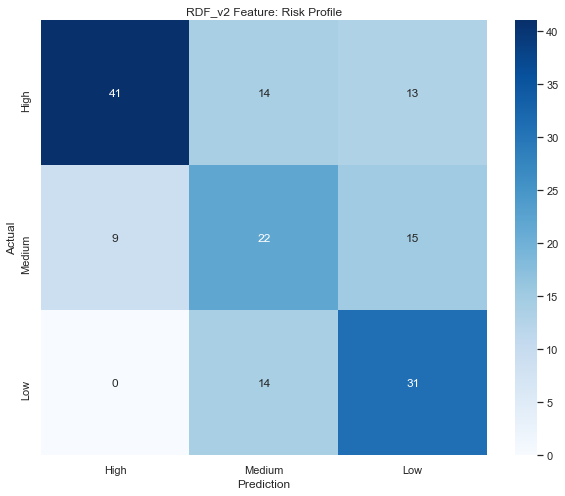

In [57]:
 ### RANDOM FOREST: Second Pass - Feature Selection

#THis chunk is here to reset 'x_train' else we need to re-run all prior cells to run this block of code
irrelevant_train_cols = ['group_next_purchase','days_next_order','customer_id']
x, y = data[data.columns.difference(irrelevant_train_cols)], data.iloc[:,data.columns == 'group_next_purchase']
y = y.values[:,0]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 123)
    
#feature selection
top_features = pd.DataFrame({'Features':x_train.columns,'Importance':rdf_v1.feature_importances_})
top_features.sort_values('Importance', ascending = False, inplace = True)
top_features.reset_index(drop = True, inplace = True)

top_features['importance_cum_sum'] = top_features.Importance.cumsum(axis = 0)

#select from 'top_features' all which yield up to this %
feature_threshold = 0.90
top_features['keep'] = top_features.importance_cum_sum.apply(lambda row: True if row < feature_threshold else False)
worst_features = top_features.loc[top_features['keep'] == False]['Features'].to_list()
                  
#identify training and testing data

irrelevant_train_cols += worst_features
x, y = data[data.columns.difference(irrelevant_train_cols)], data.iloc[:,data.columns == 'group_next_purchase']
y = y.values[:,0]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 123)

best_features = x.columns

sns.barplot(data = top_features, y = 'Features', x = 'Importance')

fig, ax = plt.subplots(figsize=(10,8))

#Randomforest to predict Y values
rdf_v2 = RandomForestClassifier()
rdf_v2.fit(x_train, y_train)


y_pred_rdf_v2 = rdf_v2.predict(x_test)

print('Random Forest: Feature Selection')
print(classification_report(y_test, y_pred_rdf_v2))


conf_matrix_rdf_v2= confusion_matrix(y_test, y_pred_rdf_v2)


df_cm_rdf_v2 = pd.DataFrame(conf_matrix_rdf_v2, index=classes, columns=classes)

ax = sns.heatmap(df_cm_rdf_v2, cmap='Blues', annot=True)
plt.title('RDF_v2 Feature: Risk Profile')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.xlabel('Prediction')

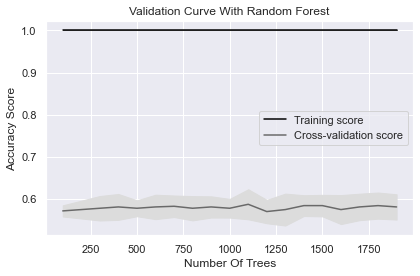

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  5.3min finished


0.6003224206349206

In [45]:
### RANDOM FOREST: Third Pass - gridsearch for optimal parameters + Feature selection
##search for best number of trees
param_range = np.arange(0,2000,100)
train_score, test_score = validation_curve(
                                RandomForestClassifier(),
                                X = x_train, y = y_train, 
                                param_name = 'n_estimators',
                                scoring = 'accuracy',
                                param_range =  param_range,
                                cv = 3, n_jobs = -1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_score, axis=1)
train_std = np.std(train_score, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_score, axis=1)
test_std = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()
##plot shows n-estimator has greatest gains 0-30 trees. Maximum appears to be ~1800
    


# hyper parameter tuning#
parameters = {'n_estimators' : [500]
              , 'criterion' : ('gini', 'entropy')
              , 'max_features' : ('auto', 'sqrt')
              , 'min_samples_split': (2,4,6,10)
              , 'min_samples_leaf': [1, 2, 4]
              , 'bootstrap' : (True, False)
              #,'min_weight_fraction_leaf' : (0.0,0.1,0.2,0.3)
              }

grid_search = GridSearchCV(RandomForestClassifier(random_state = 123)
                        , param_grid = parameters
                        , verbose = 1, n_jobs =-1
                        , cv = 10)

grid_search = grid_search.fit(x_train, y_train)
accuracy = grid_search.best_score_
best_params = grid_search.best_params_
best_params_rdf = best_params
best_params
accuracy

In [46]:
best_params

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 500}

Random Forest: Parameters Optimized
              precision    recall  f1-score   support

           0       0.85      0.65      0.73        68
           1       0.50      0.43      0.47        46
           2       0.52      0.78      0.62        45

    accuracy                           0.62       159
   macro avg       0.62      0.62      0.61       159
weighted avg       0.65      0.62      0.63       159



Text(0.5, 12.5, 'Prediction')

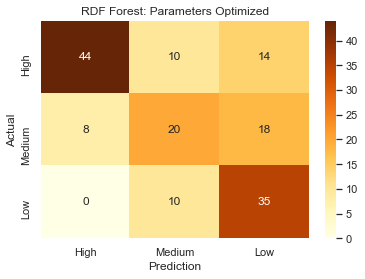

In [61]:
# Parameter Optimization

#reset training to include all relevant features
irrelevant_train_cols = ['group_next_purchase','days_next_order','customer_id']
x, y = data[data.columns.difference(irrelevant_train_cols)], data.iloc[:,data.columns == 'group_next_purchase']
y = y.values[:,0]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 123)
    
#include optimal paramaters
rdf_v3 = RandomForestClassifier(
    n_estimators = 500,
    min_samples_split = 10, min_samples_leaf = 4,
    max_features = 'auto', criterion = 'entropy',
    bootstrap = True, random_state = 123)
rdf_v3.fit(x_train, y_train)

y_pred_rdf_v3 = rdf_v3.predict(x_test)

print('Random Forest: Parameters Optimized')
print(classification_report(y_test, y_pred_rdf_v3))
conf_matrix_rdf_v3= confusion_matrix(y_test, y_pred_rdf_v3)

df_cm_rdf_v3 = pd.DataFrame(conf_matrix_rdf_v3, index=classes, columns=classes)

ax = sns.heatmap(df_cm_rdf_v3, cmap='YlOrBr', annot=True)
plt.title('RDF Forest: Parameters Optimized')
plt.ylabel('Actual')
plt.xlabel('Prediction')

The number of low risk (<1 Month) predictions is 86
The number of Medium risk (1-2 Month) predictions is 11
The nubmer of high risk (>2 Month) predictions is 62
Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        68
           1       0.36      0.09      0.14        46
           2       0.50      0.96      0.66        45

    accuracy                           0.58       159
   macro avg       0.54      0.57      0.50       159
weighted avg       0.56      0.58      0.53       159



Text(0.5, 48.5, 'Prediction')

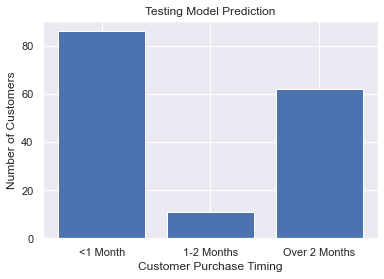

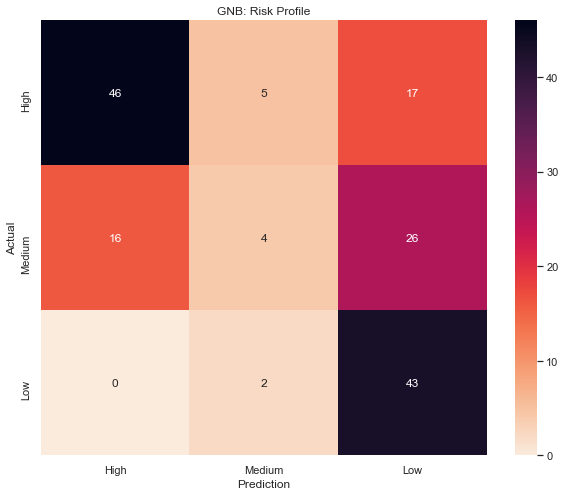

In [48]:
irrelevant_train_cols = ['group_next_purchase','days_next_order','customer_id']
x, y = data[data.columns.difference(irrelevant_train_cols)], data.iloc[:,data.columns == 'group_next_purchase']
y = y.values[:,0]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 123)


gnb = GaussianNB(priors = None)
gnb.fit(x_train,y_train)
y_pred_gnb_v1 = gnb.predict(x_test)



#graph the predictions for the testing dataset
high = 0
medium = 0
low = 0
categories = ["<1 Month", "1-2 Months","Over 2 Months"]
predictions = []

#categorize each prediction for bar graph
for group in y_pred_gnb_v1:
    if group == 0:
        low +=1
    elif group == 1:
        medium +=1
    else:
        high +=1

#append each category into a list and print the number of entries in each category
predictions.append(high)
predictions.append(medium)
predictions.append(low)
        
print("The number of low risk (<1 Month) predictions is " + str(high))
print("The number of Medium risk (1-2 Month) predictions is " + str(medium))
print("The nubmer of high risk (>2 Month) predictions is " + str(low))

#create the bar graph
plt.bar(categories, predictions)
plt.xlabel("Customer Purchase Timing")
plt.ylabel("Number of Customers")
plt.title("Testing Model Prediction")


print('Gaussian Naive Bayes')
print(classification_report(y_test, y_pred_gnb_v1))
conf_matrix_gnb_v1= confusion_matrix(y_test, y_pred_gnb_v1)

df_cm_gnb_v1 = pd.DataFrame(conf_matrix_gnb_v1, index=classes, columns=classes)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(df_cm_gnb_v1, cmap='rocket_r', annot=True)
plt.title('GNB: Risk Profile')
plt.ylabel('Actual')
plt.xlabel('Prediction')


AdaBoost: Max Depth 1
              precision    recall  f1-score   support

           0       0.75      0.40      0.52        68
           1       0.35      0.61      0.45        46
           2       0.55      0.53      0.54        45

    accuracy                           0.50       159
   macro avg       0.55      0.51      0.50       159
weighted avg       0.58      0.50      0.50       159



Text(0.5, 12.5, 'Prediction')

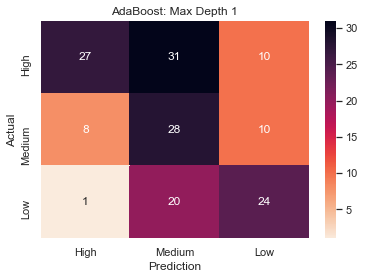

In [49]:
    ### AdaBoost
sns.axes_style("white")
               
irrelevant_train_cols = ['group_next_purchase','days_next_order','customer_id']
x, y = data[data.columns.difference(irrelevant_train_cols)], data.iloc[:,data.columns == 'group_next_purchase']
y = y.values[:,0]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 123)       

#Adaboost baseline - Decision Tree
ada_1 = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth = 1))
ada_1.fit(x_train, y_train)

y_pred_ada_v1 = ada_1.predict(x_test)

print('AdaBoost: Max Depth 1')
#Default: n_estimators = 50, learning_rate = 1
print(classification_report(y_test, y_pred_ada_v1))


conf_matrix_ada_v1 = confusion_matrix(y_test, y_pred_ada_v1)

df_cm_ada_v1 = pd.DataFrame(conf_matrix_ada_v1, index=classes, columns=classes)

ax = sns.heatmap(df_cm_ada_v1, cmap='rocket_r', annot=True)
plt.title('AdaBoost: Max Depth 1')
plt.ylabel('Actual')
plt.xlabel('Prediction')

AdaBoost: Max Depth 2
              precision    recall  f1-score   support

           0       0.76      0.32      0.45        68
           1       0.35      0.67      0.46        46
           2       0.59      0.53      0.56        45

    accuracy                           0.48       159
   macro avg       0.56      0.51      0.49       159
weighted avg       0.59      0.48      0.48       159



Text(0.5, 12.5, 'Prediction')

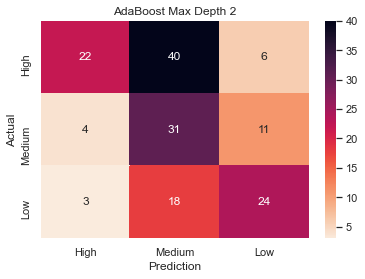

In [50]:

#Adaboost: Max Depth = 2
ada_2 = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth = 2,random_state = 123))
ada_2.fit(x_train, y_train)

y_pred_ada_v2 = ada_2.predict(x_test)

print('AdaBoost: Max Depth 2')
#Default: n_estimators = 50, learning_rate = 1
print(classification_report(y_test, y_pred_ada_v2))

conf_matrix_ada_v2 = confusion_matrix(y_test, y_pred_ada_v2)
df_cm_ada_v2 = pd.DataFrame(conf_matrix_ada_v2, index=classes, columns=classes)

ax = sns.heatmap(df_cm_ada_v2, cmap='rocket_r', annot=True)
plt.title('AdaBoost Max Depth 2')
plt.ylabel('Actual')
plt.xlabel('Prediction')

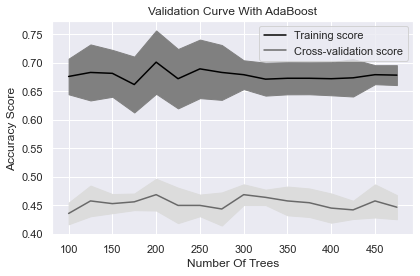

In [51]:
param_range = np.arange(100,500,25)
train_score, test_score = validation_curve(
                                AdaBoostClassifier(
                                    DecisionTreeClassifier(max_depth = 1, random_state = 123)
                                    ),
                                X = x_train, y = y_train, 
                                param_name = 'n_estimators',
                                scoring = 'accuracy',
                                param_range =  param_range,
                                cv = 3)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_score, axis=1)
train_std = np.std(train_score, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_score, axis=1)
test_std = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With AdaBoost")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

[0.4968553459119497, 0.48427672955974843, 0.37735849056603776, 0.4591194968553459, 0.5031446540880503, 0.559748427672956, 0.610062893081761, 0.559748427672956, 0.6163522012578616, 0.5345911949685535, 0.6289308176100629, 0.5974842767295597, 0.5345911949685535, 0.5408805031446541, 0.49056603773584906, 0.5094339622641509, 0.5471698113207547, 0.5094339622641509, 0.48427672955974843]
AdaBoost: Parameter Tuning
              precision    recall  f1-score   support

           0       0.82      0.59      0.68        68
           1       0.46      0.48      0.47        46
           2       0.55      0.76      0.64        45

    accuracy                           0.60       159
   macro avg       0.61      0.61      0.60       159
weighted avg       0.64      0.60      0.61       159



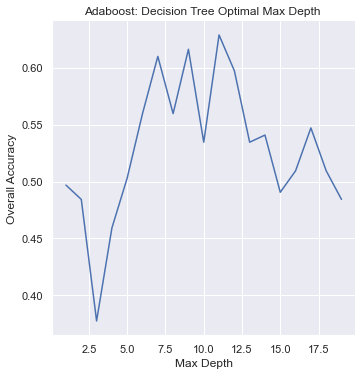

In [52]:
max_depth_range = list(range(1, 20,1))
# List to store the average RMSE for each value of max_depth:
accuracy = []
for i in max_depth_range:

    boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = i, random_state = 123))
    boost.fit(x_train, y_train)
    score = boost.score(x_test, y_test)
    accuracy.append(score)

print(accuracy)
ada_plot_v3 = sns.relplot(x = max_depth_range, y = accuracy, kind = 'line')
ada_plot_v3.set_xlabels('Max Depth')
ada_plot_v3.set_ylabels('Overall Accuracy')
plt.title('Adaboost: Decision Tree Optimal Max Depth ')


params_ada={'n_estimators':np.arange(100,350,50)
        ,'base_estimator__max_depth': [8]
        ,'learning_rate':[.001, 0.01, 0.1]
        ,"base_estimator__criterion" : ["gini", "entropy"]
        ,"base_estimator__splitter" : ["best", "random"]
        }


grid_search_ada=GridSearchCV(boost, params_ada, scoring='accuracy', n_jobs=-1)

grid_search_ada_v1 = grid_search_ada.fit(x_train, y_train)
accuracy_ada_v1 = grid_search_ada_v1.best_score_
best_params_ada = grid_search_ada_v1.best_params_
# {'learning_rate': 0.001, 'n_estimators': 100}

# List of values to try for max_depth:


ada_v3 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 8,random_state = 123, criterion = 'entropy', splitter = 'random'),
    n_estimators = 300,
    learning_rate = 0.001,
    )
ada_v3.fit(x_train, y_train)

y_pred_ada_v3 = ada_v3.predict(x_test)

print('AdaBoost: Parameter Tuning')
print(classification_report(y_test, y_pred_ada_v3))

# classes=['High', 'Medium', 'Low']
conf_matrix_ada_v3 = confusion_matrix(y_test, y_pred_ada_v3)
df_cm_ada_v3 = pd.DataFrame(conf_matrix_ada_v3, index=classes, columns=classes)


Text(0.5, 12.5, 'Prediction')

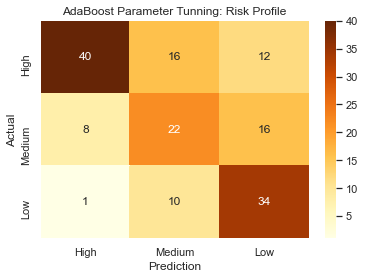

In [53]:
ax = sns.heatmap(df_cm_ada_v3, cmap='YlOrBr', annot=True)
plt.title('AdaBoost Parameter Tunning: Risk Profile')
plt.ylabel('Actual')
plt.xlabel('Prediction')

In [62]:
best_params_ada

{'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 8,
 'base_estimator__splitter': 'random',
 'learning_rate': 0.001,
 'n_estimators': 250}